In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import operator
import gc
import time

import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

import nltk
stopwords = nltk.corpus.stopwords.words("english")

import string
import re

In [2]:
dev = pd.read_csv('../csv-data/BEST&MOST200/dev-best200.csv')
train = pd.read_csv('../csv-data/BEST&MOST200/train-best200.csv')
train = pd.concat([dev, train], axis=0)
test = pd.read_csv('../csv-data/BEST&MOST200/test-best200.csv')

In [3]:
def accuracy(data, pred):
    y_true = data
    reshaped_pred = pred.reshape(3, len(pred) // 3)
    y_pred = np.argmax(reshaped_pred, axis=0)
    acc = np.mean(y_true == y_pred)
    return 'accuracy', acc, True

def train_model(X, y, X_test, params, fold_num):
    result_dict = {}
    oof = np.zeros((len(X), 3))
    prediction = np.zeros((len(X_test), 3))
    scores = []
    features = X.columns
    feature_importance = pd.DataFrame()

    folds = StratifiedKFold(n_splits=fold_num)
    
    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        print(f'\nFold {fold + 1} started at {time.ctime()}')
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = lgb.LGBMClassifier(
            **params,
            )
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric=accuracy,
                  verbose=200,
                  early_stopping_rounds=100)
        
        y_pred_val_proba = model.predict_proba(X_val)
        y_pred_val = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_test)
        
        accuracy_val = accuracy_score(y_val, y_pred_val)
        scores.append(accuracy_val)
        
        print('\nFold {0: d} accuracy: {1: .4f}'.format(fold + 1, accuracy_val))
        
        oof[val_idx] += y_pred_val_proba.reshape(-1, 3)
        prediction += y_pred_proba / fold_num
        
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = features
        fold_importance['importance'] = model.feature_importances_
        fold_importance['fold'] = fold + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
    print('\nCV mean accuracy {0: .4f}'.format(np.mean(scores)))
    
    cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False).index
    best_features = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False).reset_index()

    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['feature_importance'] = best_features
    
    plt.figure(figsize=(16,256))
    sns.barplot(x='importance', y='feature', data=best_features)
    plt.title('LGB Features (avg over folds)')
        
    return result_dict


Fold 1 started at Sun Oct 13 14:41:49 2019
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's multi_logloss: 0.832248	valid_0's accuracy: 0.653449
Early stopping, best iteration is:
[240]	valid_0's multi_logloss: 0.832182	valid_0's accuracy: 0.653985

Fold  1 accuracy:  0.6540

Fold 2 started at Sun Oct 13 14:42:09 2019
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's multi_logloss: 0.856725	valid_0's accuracy: 0.646915
Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.856182	valid_0's accuracy: 0.647527

Fold  2 accuracy:  0.6475

Fold 3 started at Sun Oct 13 14:42:26 2019
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's multi_logloss: 0.851114	valid_0's accuracy: 0.646838
Early stopping, best iteration is:
[133]	valid_0's multi_logloss: 0.85105	valid_0's accuracy: 0.647451

Fold  3 accuracy:  0.6475

Fold 4 started at Sun Oct 13 14:42:42 2019
Training until validation scores don

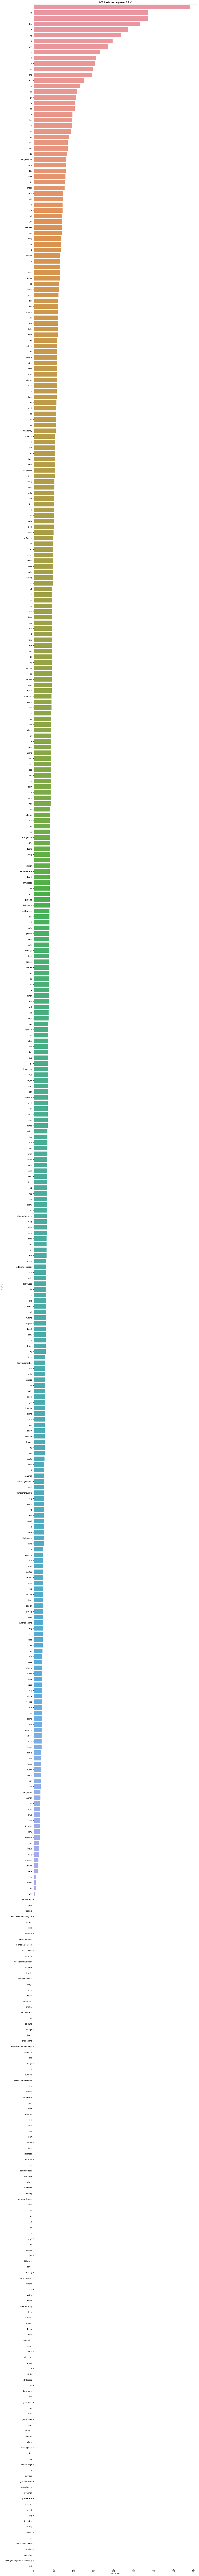

In [4]:
y = train['class']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
    
X = train.drop(['tweet-id', 'user-id', 'class'], axis=1)
X_test = test.drop(['tweet-id', 'user-id', 'class'], axis=1)

params = {
    'n_estimators': 5000,
}

result_dict = train_model(X, y, X_test, params, 10)

In [5]:
validation = train[['tweet-id', 'user-id', 'class']]
validation['class'] = encoder.inverse_transform(np.argmax(result_dict['oof'], axis=1))
accuracy_score(train['class'], validation['class'])

0.6508310811328122